<img src="img/svds_logo.png" alt="SVDS" width="500" align="left">

# PyData San Francisco 2016
## Applied Time Series Econometrics in Python (and R) Tutorial

# Abstract

Time series data is ubiquitous, both within and outside of the data science field: weekly initial unemployment claims, tick level stock prices, weekly company sales, daily number of steps taken recorded by a wearable, just to name a few. Some of the most important and commonly used data science techniques to analyze time series data are those in developed in the field of statistics. For this reason, time series statistical models should be included in any data scientist's toolkit.

This 120-minute tutorial covers the mathematical formulation, statistical foundation, and practical considerations of one of the most important classes of time series models: AutoRegression Integrated Moving Average with Explanatory Variables (ARIMAX) models, and its Seasonal counterpart (SARIMAX).

# Topics included in the Tutorial

- Common use cases of SARIMAX
- The entire class of SARIMAX models, which include Autoregressive (AR) models, Moving Average (MA) models, Mixed Autoregressive Moving Average (ARMA) models, Autoregressive Integrated Moving Average (ARIMA) models, these models with explanatory variables (ARIMAX), and these models with seasonal components and explanatory variables (SARIMAX)
- Mathematical formulation
- Underlying assumptions of this class of model
- Implementation of these models in Python and R, in which I will compare and contrast the two, using simulated and real-world time-series data, which includes
  - Exploratory time series data analysis using histogram, kernel density plot, time-series plot, scatterplot matrix, plots of autocorrelation (i.e. correlogram), and plots of partial autocorrelation 
  - Statistical estimation and its options available in Python and R
  - Simulation of these models
  - Order selection (using the celebrated Box-Jenkins approach)
  - Assumption testing and model evaluation 
  - Forecasting

# Outline of the Tutorial

### 1. Introduction

  - 1.1 Common use cases from different disciplines
  - 1.2 Common characteristics of time series
  - 1.3 The class of models to be covered today: A demo
  - Exercise 1
  
### 2. ETSDA, ARIMA Model Formulation
  - 2.1 The notion of stochastic processes, time series, and stationarity
  - 2.2 Exploratory Time Series Data Analysis
  - 2.3 Mathematical formulation of ARIMA models
  - 2.4 The Box-Jenkins Approach to ARIMA Modeling
  - Exercise 2
  
### 3. ARIMA Modeling
  - 3.1 Model Identification
  - 3.2 Model Diagnostic Checking
  - 3.3 Model performane evaluation (in-sample fit)
  - 3.4 Forecasting and forecast evaluation 
  - 3.5 A few words on adding explanatory variables, its use cases, and its practical suggestions
  - Exercise 3

### 4. SARIMA  Modeling
  - 4.1 Mathematical formulation of Seasonal ARIMA (SARIMA) models
  - 4.2 Building a seasonal ARIMA model for forecasting
  - Exercise 4

### 5. Closing Remarks: Practical suggestions and other topics
  - 5.1 Model selection heuristics
  - 5.2 Where to go from here

<div class="alert alert-success"> Note: You may note that these notebooks are, at times, fairly dense. That is because there is likely more material here than we can cover today. This was done on purpose, as there is a lot to know. My hope is that you can continue your exploration of the topic with these notebooks, even after the tutorial has ended. </div>

<div class="alert alert-warning"> Requires `statsmodels0.8.0rc1` or newer. Install with `pip install --pre statsmodels --upgrade`</div>

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
%config InlineBackend.figure_format='retina'

from __future__ import absolute_import, division, print_function

import pandas as pd
import numpy as np

import statsmodels.api as sm
import statsmodels.formula.api as smf
import statsmodels.tsa.api as smt

# Display and Plotting
import matplotlib.pylab as plt
import seaborn as sns

from ipywidgets import interactive, widgets, RadioButtons, ToggleButton, Select, FloatSlider, FloatRangeSlider, IntSlider, fixed

pd.set_option('display.float_format', lambda x: '%.5f' % x) # pandas
np.set_printoptions(precision=5, suppress=True) # numpy

pd.set_option('display.max_columns', 100)
pd.set_option('display.max_rows', 100)

# seaborn plotting style
sns.set(style='ticks', context='poster')

/anaconda3/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


# 1. Introduction
  - 1.1 Common use cases from different disciplines
  - 1.2 Common characteristics of time series
  - 1.3 The class of models to be covered today: A demo

## 1.1 Common Use Cases

- Government Budget and Key Economic Indicator Projections
- Companies forecast sales 
- CMS Projection on National Health Expenditure
- NCES Projections of Education Statistics
- Vehicular traffic flow forecasting
- Dynamic resource allocation (e.g., servers)
- Physiological models for health monitoring (e.g., glucose levels in diabetics)

## 1.2 Common characteristics of time series

* Trend
* Seasonality
* Cycles
* Combination of the above

### Pattern 1: Trend and Fluctuation around the Trend

Airline Passenger Bookings

https://datamarket.com/data/set/22u3/international-airline-passengers-monthly-totals-in-thousands-jan-49-dec-60
- `data/international-airline-passengers.csv`


In [2]:
air = pd.read_csv('data/international-airline-passengers.csv', header=0, index_col=0, parse_dates=[0])

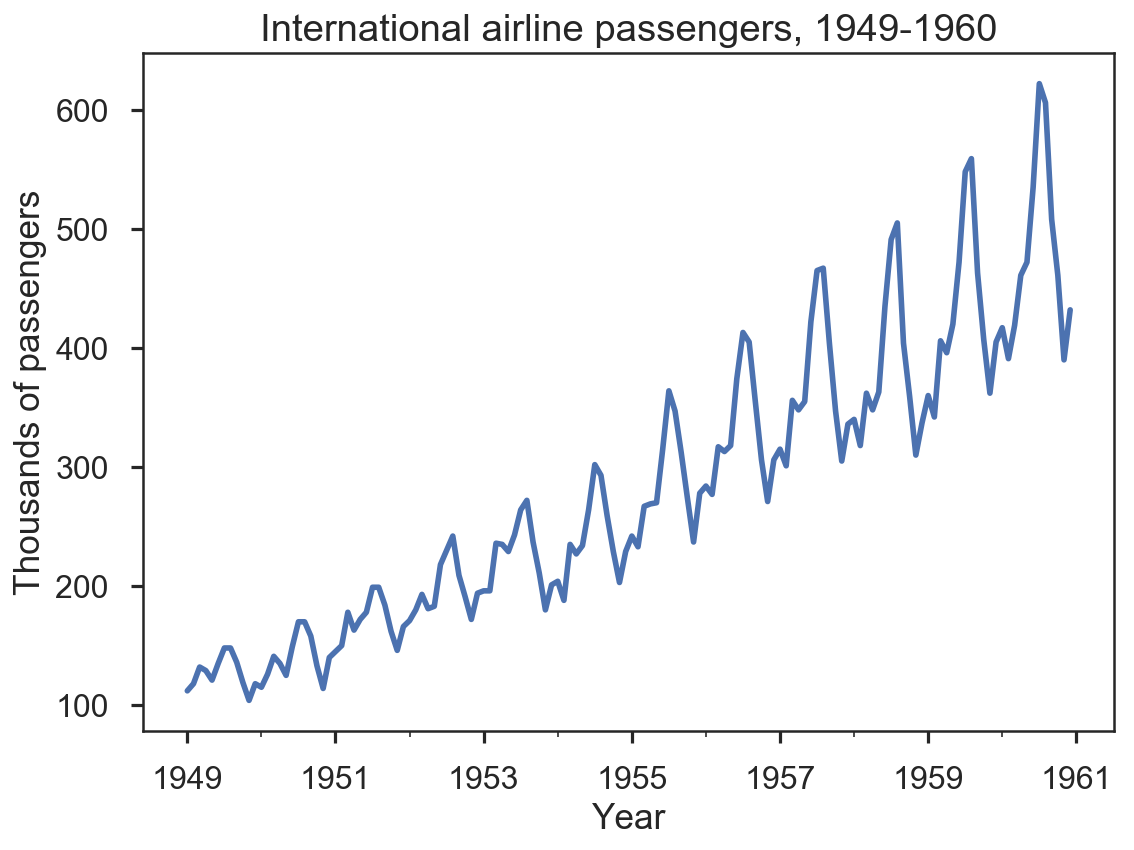

In [3]:
fig, ax = plt.subplots(figsize=(8,6));

air['n_pass_thousands'].plot(ax=ax);

ax.set_title('International airline passengers, 1949-1960');
ax.set_ylabel('Thousands of passengers');
ax.set_xlabel('Year');
ax.xaxis.set_ticks_position('bottom')
fig.tight_layout();

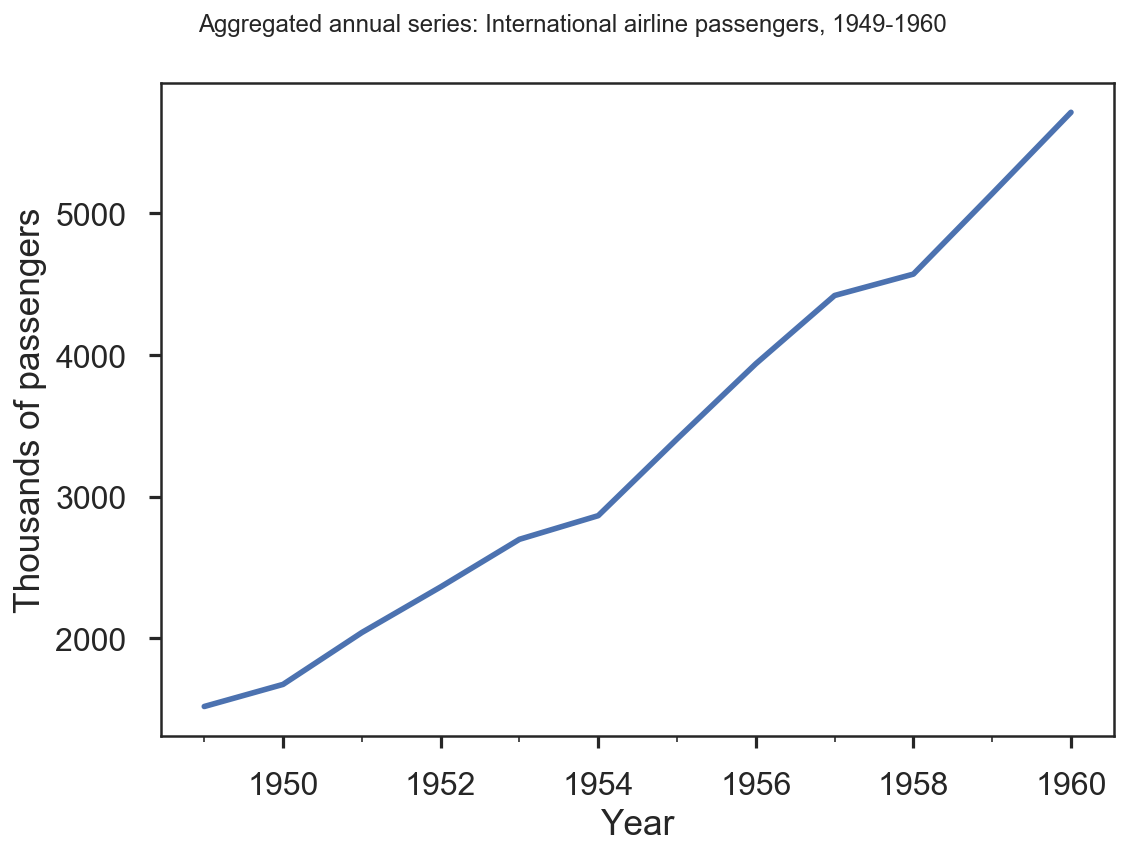

In [4]:
# Examine annual trend in the data
fig, ax = plt.subplots(figsize=(8,6));

air['n_pass_thousands'].resample('AS').sum().plot(ax=ax)

# ax.set_title('Aggregated annual series: International airline passengers, 1949-1960');
fig.suptitle('Aggregated annual series: International airline passengers, 1949-1960');
ax.set_ylabel('Thousands of passengers');
ax.set_xlabel('Year');
ax.xaxis.set_ticks_position('bottom')
fig.tight_layout();
fig.subplots_adjust(top=0.9)

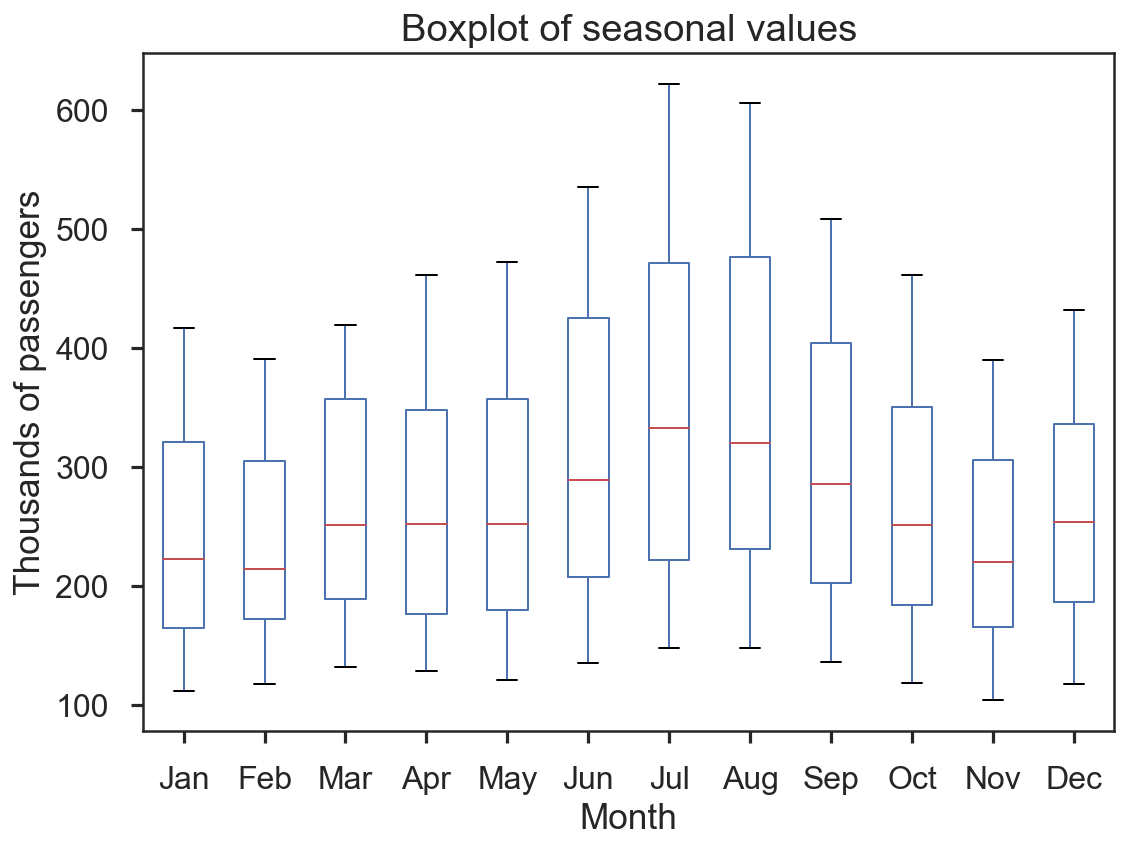

In [5]:
# Examine seasonal trend in the data
air['Month'] = air.index.strftime('%b')
air['Year'] = air.index.year

air_piv = air.pivot(index='Year', columns='Month', values='n_pass_thousands')

air = air.drop(['Month', 'Year'], axis=1)

# put the months in order
month_names = pd.date_range(start='2016-01-01', periods=12, freq='MS').strftime('%b')
air_piv = air_piv.reindex(columns=month_names)

# plot it
fig, ax = plt.subplots(figsize=(8, 6))
air_piv.plot(ax=ax, kind='box');

ax.set_xlabel('Month');
ax.set_ylabel('Thousands of passengers');
ax.set_title('Boxplot of seasonal values');
ax.xaxis.set_ticks_position('bottom')
fig.tight_layout();

### Pattern 2: Trend and Change in Structure

Annual Average Global Temperature Change

http://data.giss.nasa.gov/gistemp/graphs/graph_files.html - Land-Ocean: Global Means
- `data/mixedGLB.Ts.ERSSTV4.GHCN.CL.PA.csv`

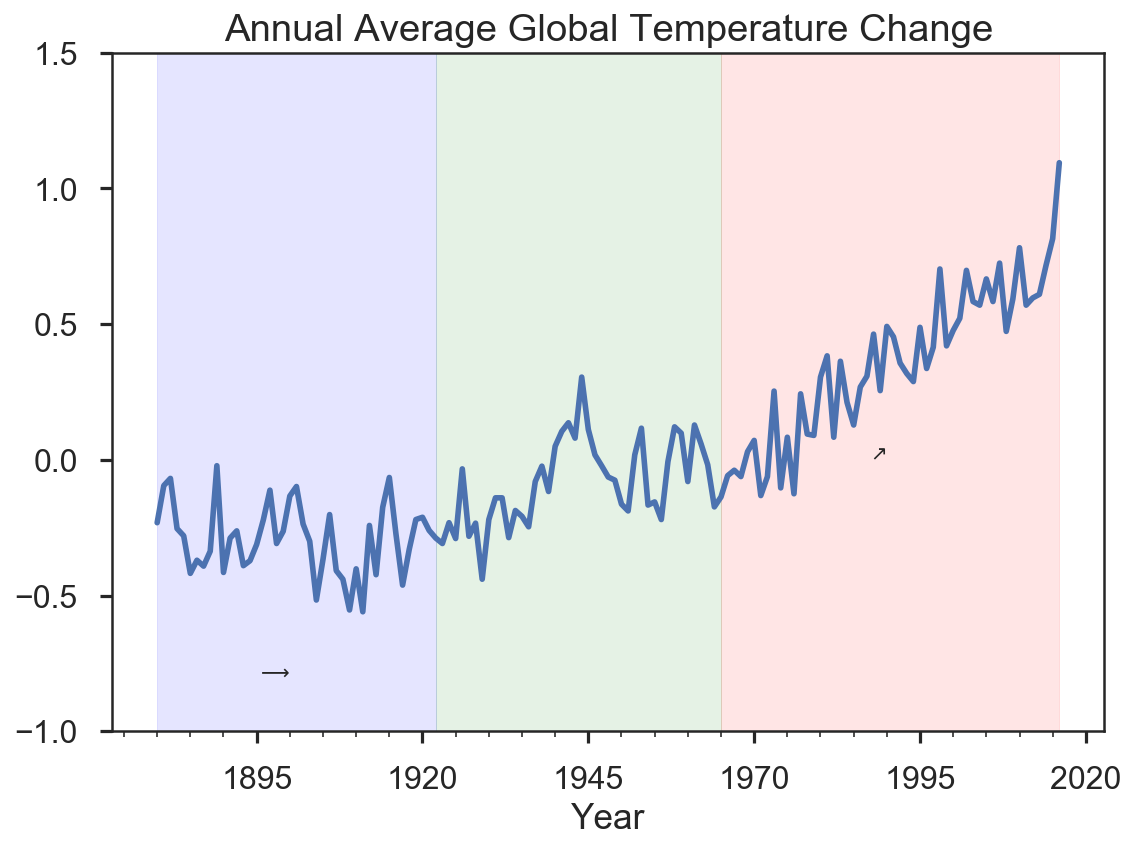

In [6]:
gtemp = pd.read_csv('data/mixedGLB.Ts.ERSSTV4.GHCN.CL.PA.csv', header=1, index_col=0, parse_dates=[0])
gtemp['avg'] = gtemp.iloc[:,:12].mean(axis=1)

fig, ax = plt.subplots(figsize=(8, 6));

gtemp['avg'].plot(ax=ax);

ax.set_title('Annual Average Global Temperature Change');

ylim = (-1.0, 1.5)
ax.set_ylim(ylim)

ax.fill_betweenx(ylim, gtemp.index[0], pd.Timestamp('1922'), alpha=.1, zorder=-1, color='b');
ax.fill_betweenx(ylim, pd.Timestamp('1922'), pd.Timestamp('1965'), alpha=.1, zorder=-1, color='g');
ax.fill_betweenx(ylim, pd.Timestamp('1965'), gtemp.index[-1], alpha=.1, zorder=-1, color='r');

ax.annotate('$\\longrightarrow$', (gtemp.index[15], -0.8));
ax.annotate('$\\nearrow$', (gtemp.index[-30], 0));
ax.xaxis.set_ticks_position('bottom')
fig.tight_layout();

### Pattern 3: Variation around a Stable Mean

Dow Jones Industrial Average
- `data/dji.csv`

```python
import pandas_datareader.data as web

start = pd.Timestamp('2006-04-20')
end = pd.Timestamp('2016-04-20')

dji = web.DataReader("^DJI", 'yahoo', start, end)

dji['Return_log'] = dji['Close'].apply(lambda x: np.log(x)).diff()

dji.to_csv('data/dji.csv')
```

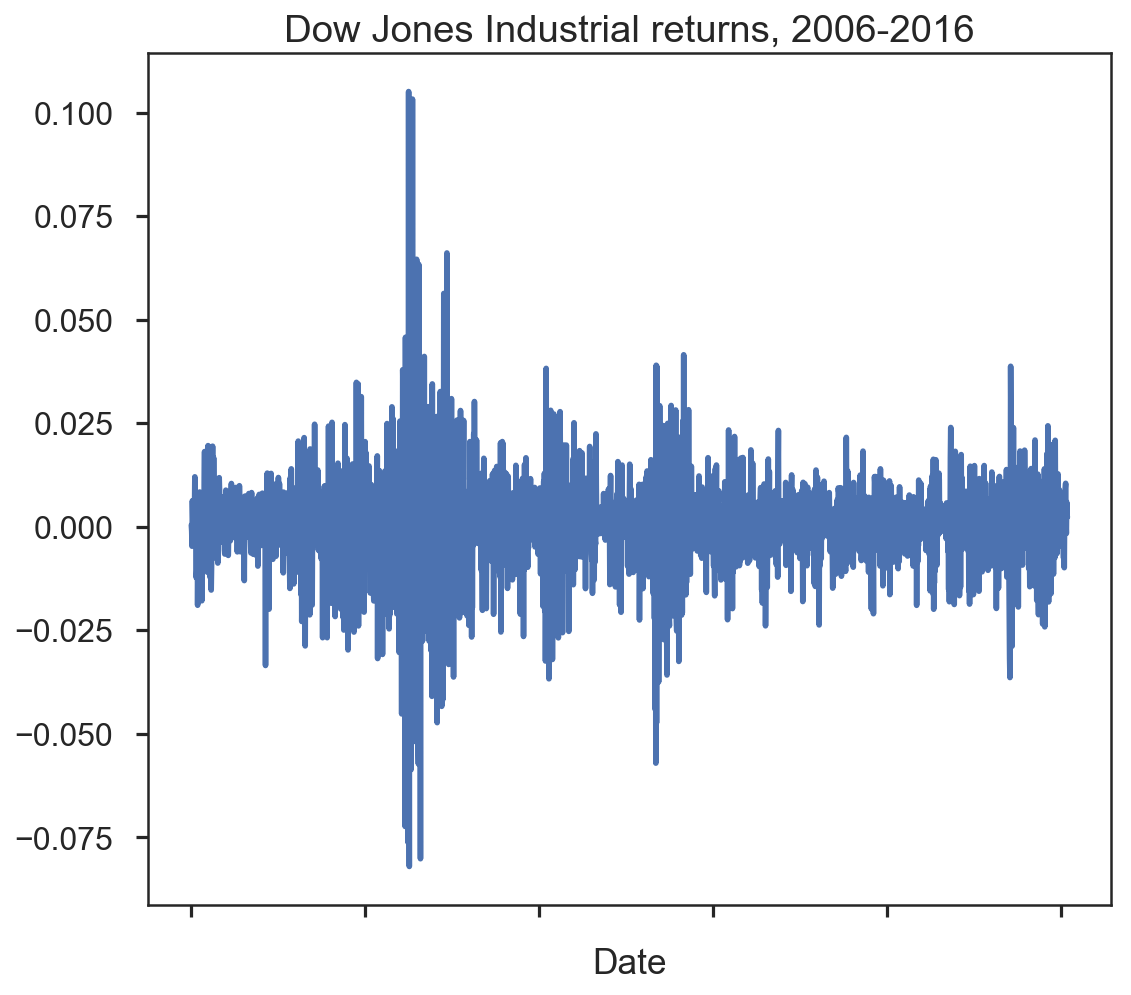

In [7]:
dji = pd.read_csv('data/dji.csv', header=0, index_col=0)

fig, ax = plt.subplots(figsize=(8, 7))

dji['Return_log'].plot(ax=ax);

ax.set_title('Dow Jones Industrial returns, 2006-2016');
ax.xaxis.set_ticks_position('bottom')
fig.tight_layout();

### Pattern 4: Cycles/Periodicity

Number of annual sunspots

In [8]:
print(sm.datasets.sunspots.NOTE)

::

    Number of Observations - 309 (Annual 1700 - 2008)
    Number of Variables - 1
    Variable name definitions::

        SUNACTIVITY - Number of sunspots for each year

    The data file contains a 'YEAR' variable that is not returned by load.



In [9]:
sun = sm.datasets.sunspots.load_pandas().data
sun['YEAR'] = pd.to_datetime(sun['YEAR'].astype(int), format='%Y')
sun = sun.set_index('YEAR')

In [10]:
def tsplot(y, lags=None, title='', figsize=(14, 8)):
    '''Examine the patterns of ACF and PACF, along with the time series plot and histogram.
    
    Original source: https://tomaugspurger.github.io/modern-7-timeseries.html
    '''
    fig = plt.figure(figsize=figsize)
    layout = (2, 2)
    ts_ax   = plt.subplot2grid(layout, (0, 0))
    hist_ax = plt.subplot2grid(layout, (0, 1))
    acf_ax  = plt.subplot2grid(layout, (1, 0))
    pacf_ax = plt.subplot2grid(layout, (1, 1))
    
    y.plot(ax=ts_ax)
    ts_ax.set_title(title)
    y.plot(ax=hist_ax, kind='hist', bins=25)
    hist_ax.set_title('Histogram')
    smt.graphics.plot_acf(y, lags=lags, ax=acf_ax)
    smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax)
    [ax.set_xlim(0) for ax in [acf_ax, pacf_ax]]
    sns.despine()
    plt.tight_layout()
    return ts_ax, acf_ax, pacf_ax

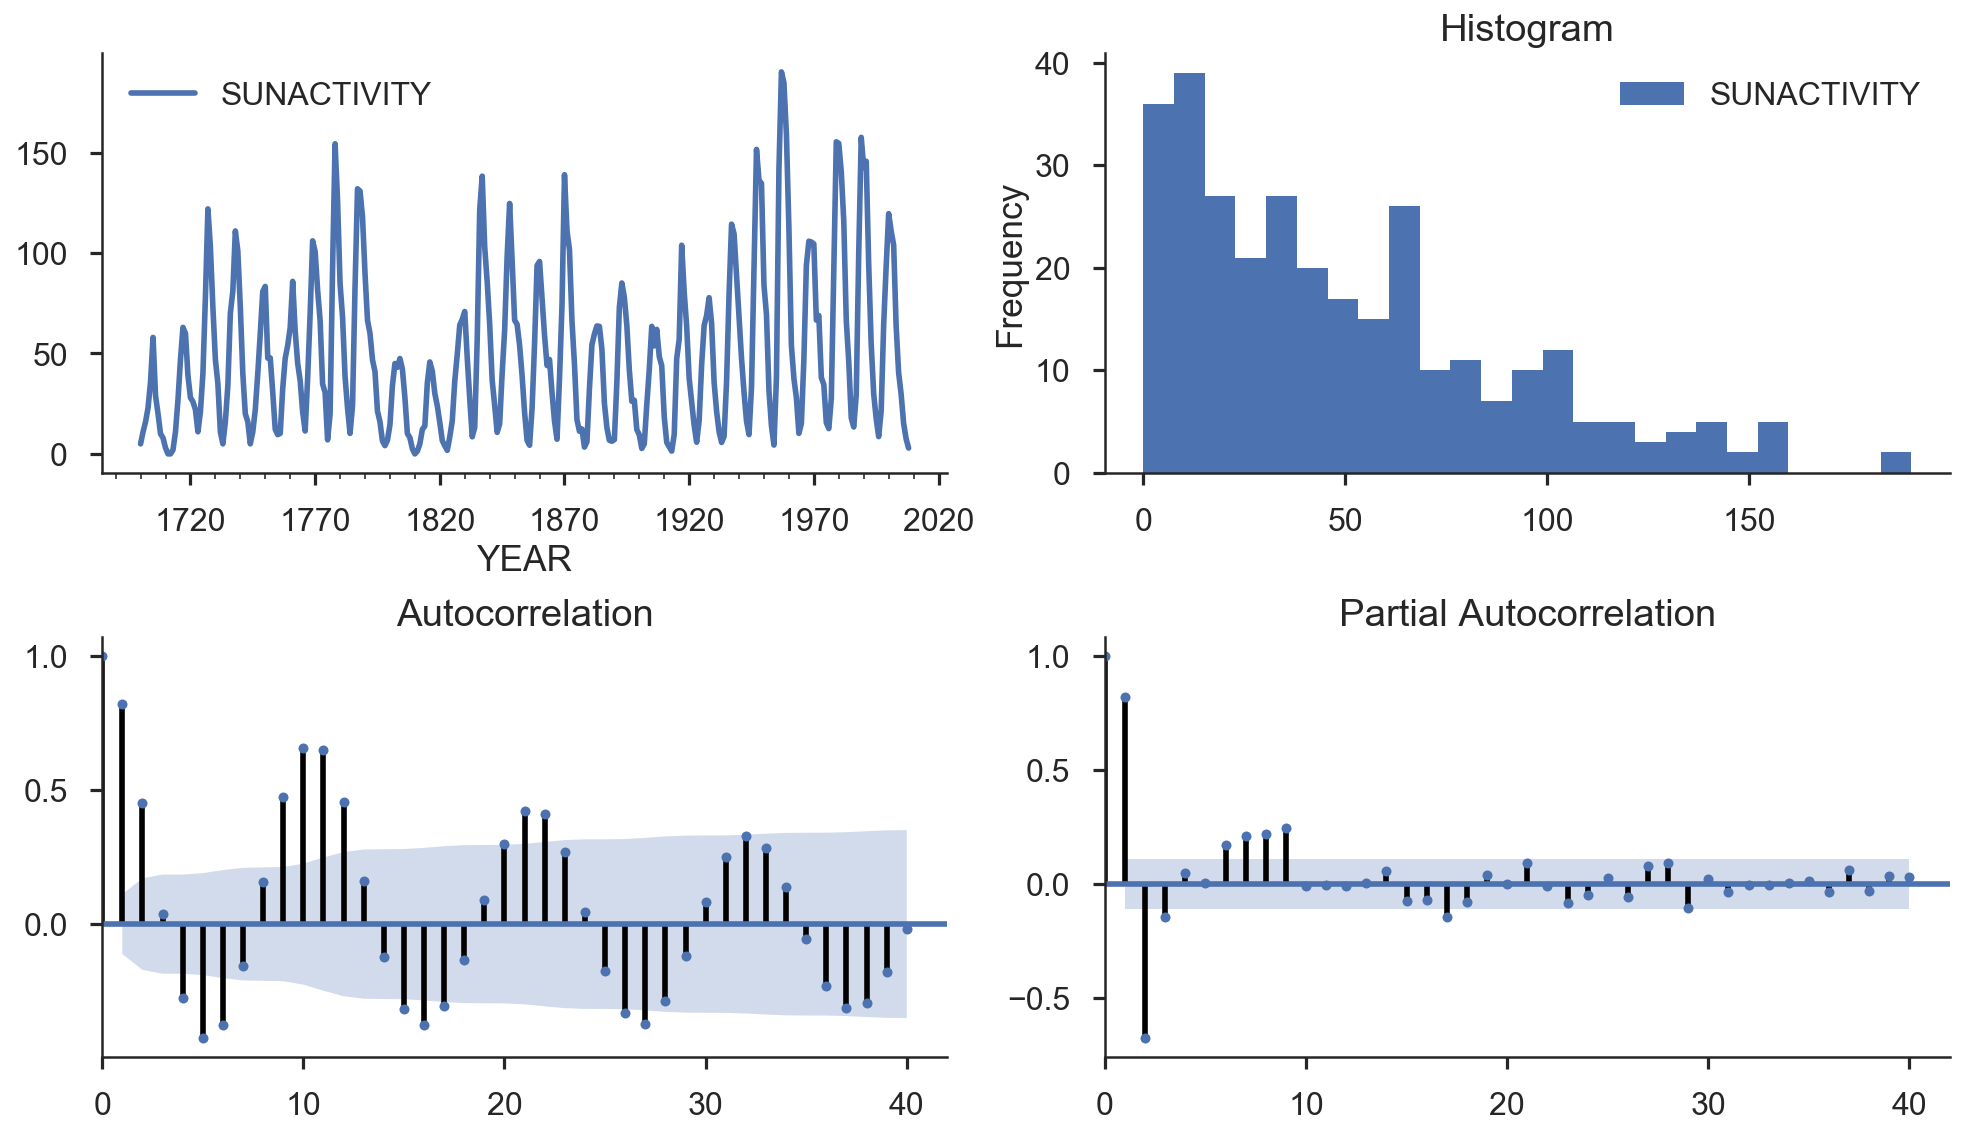

In [11]:
tsplot(sun, lags=40);

## 1.3 Demo: Plot and model data generated from ARIMA process

In [12]:
def generate_arima_data(arparams,
                        maparams,
                        i_order=0,
                        n_samp=120,
                        rng_state=None,
                        sigma=1,
                        burnin=10,
                        lin_trend=None,
                        verbose=True,
                        ):
    
    if rng_state is None:
        rng_state = np.random.RandomState()
    ar = np.r_[1, -arparams] # add zero-lag and negate
    ma = np.r_[1, maparams] # add zero-lag
    
    if verbose:
        arma_process = smt.ArmaProcess(ar, ma, nobs=n_samp)
        print('Is the process stationary? {}'.format(arma_process.isstationary))
        print('Is the process invertible? {}'.format(arma_process.isinvertible))

    y = smt.arma_generate_sample(ar, ma, n_samp, sigma=sigma, distrvs=rng_state.randn, burnin=burnin)
    # add deterministic linear trend
    if lin_trend is not None:
        y = y + np.cumsum(np.repeat(lin_trend, n_samp))
    for i in range(i_order):
        y = y.cumsum()
    
    return y

In [13]:
# the function for generating data and plotting
def arima_data(n_samp=120,
               ar_gen=0,
               ar1_coef=0,
               ar2_coef=0,
               ar3_coef=0,
               ar4_coef=0,
               i_gen=0,
               ma_gen=0,
               ma1_coef=0,
               ma2_coef=0,
               ma3_coef=0,
               ma4_coef=0,
               rand_state=42,
               ylim=5,
               ar_fit_p=0,
               i_fit_d=0,
               ma_fit_q=0,
               n_train=108,
               n_forecast=24,
               dynamic=False,
               lin_trend=None,
               verbose=True,
               ):
    
    rng_state = np.random.RandomState(rand_state)

    arparams = np.array([ar1_coef, ar2_coef, ar3_coef, ar4_coef])
    arparams = arparams[:ar_gen]
    maparams = np.array([ma1_coef, ma2_coef, ma3_coef, ma4_coef])
    maparams = maparams[:ma_gen]
    
    print('Generated ARIMA({}, {}, {})'.format(ar_gen, i_gen, ma_gen))
    print('AR coeff = {}, MA coeff = {}'.format(arparams, maparams))
    
    y = generate_arima_data(arparams,
                            maparams,
                            i_gen,
                            n_samp=n_samp,
                            rng_state=rng_state,
                            lin_trend=lin_trend,
                            verbose=verbose,
                            )
    
    # set a fake DatetimeIndex
    df = pd.DataFrame(data=y, columns=['value'], index=pd.date_range(start='1990-01-01', freq='MS', periods=len(y)))
    
    fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(16, 5))
    
    ax1.plot(df.iloc[:n_train]['value'], label='In-sample data', linestyle='-')
    # subtract 1 only to connect it to previous point in the graph
    ax1.plot(df.iloc[n_train-1:]['value'], label='Held-out data', linestyle='--')

    fitting=False
    if (((ar_gen > 0) and (ar1_coef != 0)) or ((ma_gen > 0) and (ma1_coef != 0))) and ((ar_fit_p > 0) or (ma_fit_q > 0)):
        fitting=True
        print('Fit ARIMA({}, {}, {})'.format(ar_fit_p, i_fit_d, ma_fit_q))
        
        training = df.iloc[:n_train]['value']
        
        if (lin_trend is not None) and (lin_trend > 0):
            #trend='t'
            
            # there's a bug in statsmodels 0.8.0rc1 regarding trend that has been fixed
            # https://github.com/statsmodels/statsmodels/issues/3111
            trend='n'
        else:
            trend='n'
        model = smt.SARIMAX(training, order=(ar_fit_p, i_fit_d, ma_fit_q),
                            trend=trend,
                            enforce_stationarity=False,
                            enforce_invertibility=False,
                            )
        results = model.fit()
        
        pred_begin = df.index[results.loglikelihood_burn]
        pred_end =  df.index[n_train] + pd.DateOffset(months = n_forecast - 1)
        pred = results.get_prediction(start=pred_begin.strftime('%Y-%m-%d'),
                                      end=pred_end.strftime('%Y-%m-%d'),
                                      dynamic=dynamic)
        pred_mean = pred.predicted_mean
        pred_ci = pred.conf_int(alpha=0.05)
        
        ax1.plot(pred_mean, 'r', alpha=.6, label='Predicted values')
        ax1.fill_between(pred_ci.index,
                         pred_ci.iloc[:, 0],
                         pred_ci.iloc[:, 1], color='k', alpha=.2)
        # plot the residuals
        (df['value'] - pred_mean).dropna().plot(ax=ax2, marker='o')
        ax2.set_xlim((df.index[0], pred_end))
        ax2.set_title('Residuals ($data - model$)');
        ax2.axhline(y=0, linestyle='--', color='k', alpha=.5);
        
    # scale with i_gen
    ylim = ylim*(10**(i_gen))
    ax1.set_ylim((-ylim, ylim));
    ax1.legend(loc='best');
    
    if fitting:
        ax1.fill_betweenx(ax1.get_ylim(), df.index[n_train], pred_end, alpha=.1, zorder=-1)
        ax2.fill_betweenx(ax2.get_ylim(), df.index[n_train], pred_end, alpha=.1, zorder=-1)
        plt.show();
        print(results.summary())
    pass

In [14]:
# set up the widgets
n_samp=120

n_train=108
n_forecast=24

rand_state_init=42
ylim_init=5

# orders
int_min = 0
int_max = 4
int_step = 1

# sliders for data generation
ar_gen_slider = IntSlider(value=0, min=int_min, max=int_max, step=int_step, continuous_update=False)
i_gen_slider = IntSlider(value=0, min=int_min, max=int_max, step=int_step, continuous_update=False)
ma_gen_slider = IntSlider(value=0, min=int_min, max=int_max, step=int_step, continuous_update=False)

# coefficients
lag_min = -1
lag_max = 1
lag_step = 0.1

ar1_coef_slider = FloatSlider(value=0, min=lag_min, max=lag_max, step=lag_step, continuous_update=False)
ar2_coef_slider = FloatSlider(value=0, min=lag_min, max=lag_max, step=lag_step, continuous_update=False)
ar3_coef_slider = FloatSlider(value=0, min=lag_min, max=lag_max, step=lag_step, continuous_update=False)
ar4_coef_slider = FloatSlider(value=0, min=lag_min, max=lag_max, step=lag_step, continuous_update=False)

ma1_coef_slider = FloatSlider(value=0, min=lag_min, max=lag_max, step=lag_step, continuous_update=False)
ma2_coef_slider = FloatSlider(value=0, min=lag_min, max=lag_max, step=lag_step, continuous_update=False)
ma3_coef_slider = FloatSlider(value=0, min=lag_min, max=lag_max, step=lag_step, continuous_update=False)
ma4_coef_slider = FloatSlider(value=0, min=lag_min, max=lag_max, step=lag_step, continuous_update=False)

rand_slider = IntSlider(value=rand_state_init, min=0, max=10000, step=1, continuous_update=False)
ylim_slider = IntSlider(value=ylim_init, min=1, max=100, step=1, continuous_update=False)

# initial values and sliders for model parameters
ar_fit_p_init=0
i_fit_d_init=0
ma_fit_q_init=0
ar_fit_p_slider = IntSlider(value=ar_fit_p_init, min=int_min, max=int_max, step=int_step, continuous_update=False)
i_fit_d_slider = IntSlider(value=i_fit_d_init, min=int_min, max=int_max, step=int_step, continuous_update=False)
ma_fit_q_slider = IntSlider(value=ma_fit_q_init, min=int_min, max=int_max, step=int_step, continuous_update=False)

# dynamic_init=n_train
# dynamic_slider = IntSlider(value=dynamic_init, min=n_train-10, max=n_train+1, step=int_step, continuous_update=False)

# lin_trend_init = 0
# lin_trend_slider = FloatSlider(value=lin_trend_init, min=0, max=1.0, step=0.1, continuous_update=False)

arima_w = interactive(
    arima_data,
    n_samp=fixed(n_samp),
    ar_gen=ar_gen_slider,
    ar1_coef=ar1_coef_slider,
    ar2_coef=ar2_coef_slider,
    ar3_coef=ar3_coef_slider,
    ar4_coef=ar4_coef_slider,
    i_gen=i_gen_slider,
    ma_gen=ma_gen_slider,
    ma1_coef=ma1_coef_slider,
    ma2_coef=ma2_coef_slider,
    ma3_coef=ma3_coef_slider,
    ma4_coef=ma4_coef_slider,
    rand_state=rand_slider,
    ylim=ylim_slider,
    ar_fit_p=ar_fit_p_slider,
    i_fit_d=i_fit_d_slider,
    ma_fit_q=ma_fit_q_slider,
    n_train=fixed(n_train),
    n_forecast=fixed(n_forecast),
    dynamic=fixed(False),
    #dynamic=dynamic_slider,
    lin_trend=fixed(None),
    #lin_trend=lin_trend_slider,
    verbose=fixed(True),
    )

# arrange the widgets
arima_widget = widgets.HBox([widgets.VBox(arima_w.children[:6]),
                             widgets.VBox(arima_w.children[6:11]),
                             widgets.VBox(arima_w.children[11:]),
                             ])
# this is the set of widgets in the function with defaults
arima_widget.on_displayed(lambda x: arima_data(ar_gen=0,
                                                ar1_coef=0,
                                                ar2_coef=0,
                                                ar3_coef=0,
                                                ar4_coef=0,
                                                i_gen=0,
                                                ma_gen=0,
                                                ma1_coef=0,
                                                ma2_coef=0,
                                                ma3_coef=0,
                                                ma4_coef=0,
                                                rand_state=rand_state_init,
                                                ylim=ylim_init,
                                                ar_fit_p=ar_fit_p_init,
                                                i_fit_d=i_fit_d_init,
                                                ma_fit_q=ma_fit_q_init,
                                                n_train=n_train,
                                                #dynamic=dynamic_init,
                                                #lin_trend=lin_trend_init,
                                                ))

HBox(children=(VBox(children=(IntSlider(value=0, continuous_update=False, description='ar_gen', max=4), FloatSlider(value=0.0, continuous_update=False, description='ar1_coef', max=1.0, min=-1.0), FloatSlider(value=0.0, continuous_update=False, description='ar2_coef', max=1.0, min=-1.0), FloatSlider(value=0.0, continuous_update=False, description='ar3_coef', max=1.0, min=-1.0), FloatSlider(value=0.0, continuous_update=False, description='ar4_coef', max=1.0, min=-1.0), IntSlider(value=0, continuous_update=False, description='i_gen', max=4))), VBox(children=(IntSlider(value=0, continuous_update=False, description='ma_gen', max=4), FloatSlider(value=0.0, continuous_update=False, description='ma1_coef', max=1.0, min=-1.0), FloatSlider(value=0.0, continuous_update=False, description='ma2_coef', max=1.0, min=-1.0), FloatSlider(value=0.0, continuous_update=False, description='ma3_coef', max=1.0, min=-1.0), FloatSlider(value=0.0, continuous_update=False, description='ma4_coef', max=1.0, min=-1.0))), VBox(children=(IntSlider(value=42, continuous_update=False, description='rand_state', max=10000), IntSlider(value=5, continuous_update=False, description='ylim', min=1), IntSlider(value=0, continuous_update=False, description='ar_fit_p', max=4), IntSlider(value=0, continuous_update=False, description='i_fit_d', max=4), IntSlider(value=0, continuous_update=False, description='ma_fit_q', max=4), Output()))))

Generated ARIMA(0, 0, 0)
AR coeff = [], MA coeff = []
Is the process stationary? True
Is the process invertible? True


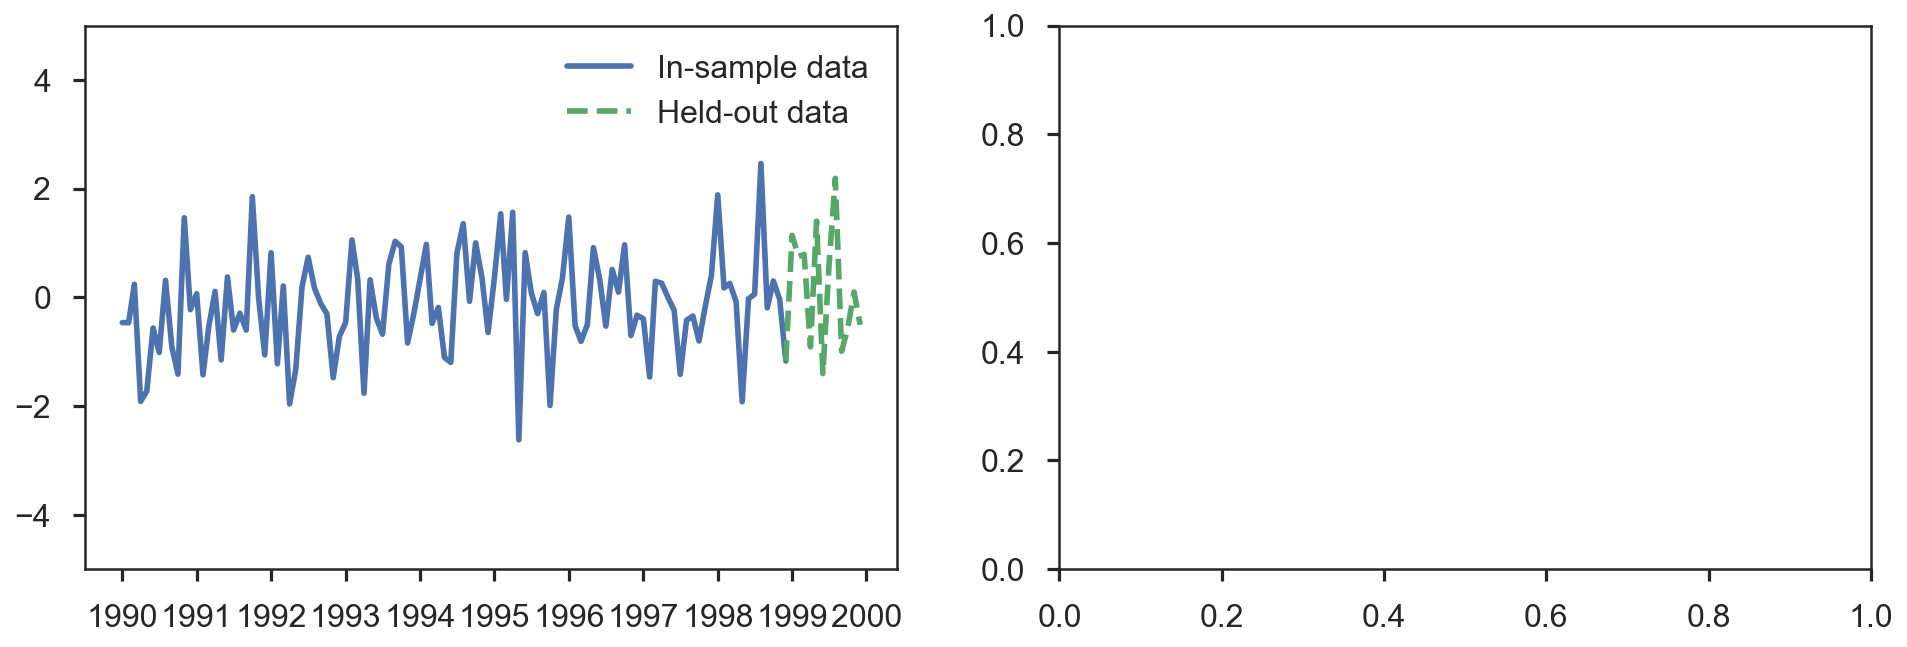

In [15]:
arima_widget

### Exericse 1

1. Write down 2 - 4 examples of time series that you encouter in real life.
2. Use the widget above to simulate a number of time series. Are there any of them that resemble the ones that you encounter in real life?